# Jokic's assists vs. Murray's points

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy.stats
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# We wanna see all columns of a DataFrame
pd.set_option('display.max_columns', None)

## 1. Data load and some processing

In [3]:
data = pd.read_csv('model_data.csv')
data.head()

,WIN,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST,PLAYOFFS
0,1,8,3,5,0,3,4,94,38,15,0
1,0,6,6,0,9,1,2,71,41,13,0
2,1,13,14,10,10,1,5,87,30,6,0
3,1,19,10,7,9,3,0,88,27,18,0
4,1,21,12,4,16,5,5,97,33,22,0


In [4]:
print("All games: " + str(len(data)))
print("Regular season games: " + str(len(data[data['PLAYOFFS'] == 0])))

All games: 372
Regular season games: 319


While it's commonly accepted that playoff games are different from regular season games, for illustrative purposes, we'll focus the analysis using all the games. There're 372 games where both Jokic and Murray were starters.

In [5]:
# We drop the column 'PLAYOFFS'
data.drop('PLAYOFFS', axis = 1, inplace = True)

# We drop the column 'WIN' from the predictors and use it as the target 
cols = data.columns.to_list()[1:]
X_train = data[cols].copy()
y_train = data['WIN'].copy()
X_train.head(2)

,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST
0,8,3,5,0,3,4,94,38,15
1,6,6,0,9,1,2,71,41,13


In [6]:
y_train.head(2)

0    1
1    0
Name: WIN, dtype: int64

## 2. Logistic regression

- [Interpret logistic regression coefficients [for beginners]](https://quantifyinghealth.com/interpret-logistic-regression-coefficients/)
- [Testing the equality of two regression coefficients](https://andrewpwheeler.com/2016/10/19/testing-the-equality-of-two-regression-coefficients/)
- [Logistic regression with scikit-learn](https://solegaonkar.github.io/SktlearnLogisticRegression.html)

### 2.1. Unstandardized coefficients

Assessing the relative importance of predictors (e.g., Jokic's assists vs. Murray's points) by comparing their unstandardized coefficients is inadequate. Unstandardized coefficients are used to interpret the effect of an individual predictor on the dependent variable, not to compare the effects of several predictors on the dependent variable.

Nonetheless, I provide the analysis for the sake of completeness and as a learning exercise.

#### 2.1.1. Using `statsmodels`

In [7]:
X_train['Intercept'] = 1
log_reg = sm.Logit(y_train,  X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.500212
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    WIN   No. Observations:                  372
Model:                          Logit   Df Residuals:                      362
Method:                           MLE   Df Model:                            9
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                  0.2381
Time:                        18:16:30   Log-Likelihood:                -186.08
converged:                       True   LL-Null:                       -244.24
Covariance Type:            nonrobust   LLR p-value:                 7.529e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JOKIC_PTS      0.0444      0.020      2.249      0.024       0.006       0.083
JOKIC_REB      0.1865      0.

According to the results, a 1-AST increase by Jokic increases the odds of winning by 11.48%, while a 1-PTS increase by Murray increases the odds of winning by 9.02%.

$e^{\beta_{JOKIC\_AST}} = e^{0.1087} = 1.11483$

$e^{\beta_{MURRAY\_PTS}} = e^{0.0864} = 1.09024$

We can also compare the coefficients using the output from the variance-covariance matrix. The diagonal from the variance-covariance matrix corresponds to the variances of each estimate. If we take their square roots, we'd get the standard errors reported in the regression output.

In [8]:
log_reg.cov_params()

,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST,Intercept
JOKIC_PTS,0.000389,-0.000059,-0.000175,0.000128,0.000021,-0.000423,0.000183,0.000068,-0.000148,-0.019671
JOKIC_REB,-0.000059,0.001547,-0.000199,0.000085,0.000135,0.000355,0.000084,0.000185,0.000234,-0.031637
JOKIC_AST,-0.000175,-0.000199,0.002228,-0.000286,-0.000011,0.000455,-0.000275,0.000172,0.000672,-0.002017
MURRAY_PTS,0.000128,0.000085,-0.000286,0.000399,-0.000231,-0.000222,0.000172,0.000107,-0.000112,-0.020560
MURRAY_REB,0.000021,0.000135,-0.000011,-0.000231,0.004080,-0.000247,0.000155,0.000037,-0.000138,-0.022517
MURRAY_AST,-0.000423,0.000355,0.000455,-0.000222,-0.000247,0.003584,-0.000190,0.000194,0.000756,-0.012774
REST_PTS,0.000183,0.000084,-0.000275,0.000172,0.000155,-0.000190,0.000273,0.000008,-0.000337,-0.020275
REST_REB,0.000068,0.000185,0.000172,0.000107,0.000037,0.000194,0.000008,0.000608,0.000049,-0.026521
REST_AST,-0.000148,0.000234,0.000672,-0.000112,-0.000138,0.000756,-0.000337,0.000049,0.001823,-0.008510
Intercept,-0.019671,-0.031637,-0.002017,-0.020560,-0.022517,-0.012774,-0.020275,-0.026521,-0.008510,3.612469


$d = \beta_{JOKIC\_AST} - \beta_{MURRAY\_PTS}$

$d = 0.1087 - 0.0864 = 0.0223$

$SE(d) = \sqrt{VAR(\beta_{JOKIC\_AST}) + VAR(\beta_{MURRAY\_PTS}) - 2 \times COV(\beta_{JOKIC\_AST}, \beta_{MURRAY\_PTS})}$

$SE(d) = \sqrt{0.002228 + 0.000399 - 2 \times (-0.000286)} = 0.0566$

$z = {d \over SE(d)}$

$z = {0.0223 \over 0.0566} = 0.39$

When comparing these coefficients, there's no a significant difference between them ($z = 0.39$, $p = 0.69$).

#### 2.1.2. Using `scikit-learn`

There's no need to include the intercept since `scikit-learn` does it by default. $L2$ regularization and $C = 1$ are also default.

Note that the coefficients are virtually the same compared to the ones obtained with `statsmodels`.

In [9]:
log_reg_sl = LogisticRegression(max_iter = 200)
log_reg_sl.fit(X_train[cols], y_train)
print(log_reg_sl.coef_)
print(log_reg_sl.intercept_)

[[0.04442388 0.18615798 0.10845817 0.08637621 0.07554491 0.12705135
  0.06906425 0.10902042 0.05802761]]
[-14.55456822]


##### Regularization

No regularization

```python
log_reg_sl = LogisticRegression(max_iter = 200, penalty = None)
log_reg_sl.fit(X_train[cols], y_train)
print(log_reg_sl.coef_)
print(log_reg_sl.intercept_)
```

Change the parameter $C$ to play with the $L2$ regularization strength: the lower the $C$, the stronger the regularization. Try $C = 0.01$, $0.1$, $10$ and $100$.

```python
log_reg_sl = LogisticRegression(max_iter = 200, C = 0.01)
log_reg_sl.fit(X_train[cols], y_train)
print(log_reg_sl.coef_)
print(log_reg_sl.intercept_)
```

### 2.2. Standardized coefficients

By standardizing the predictors, their effects on the dependent variable become comparable, making possible to assess their relative importance. However, this approach can be misleading since differences in standardized coefficients could arise due to differences in their standard deviations.

Let's take a look at Jokic's AST and Murray's PTS descriptive stats.

In [10]:
X_train[cols].describe()

,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,21.887097,10.956989,7.537634,19.432796,4.072581,4.951613,70.677419,29.395161,14.112903
std,8.964629,3.949585,3.386382,8.908235,2.173747,2.572469,14.148356,6.140079,4.270900
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,31.000000,14.000000,4.000000
25%,16.000000,8.000000,5.000000,14.000000,2.000000,3.000000,61.000000,25.000000,11.000000
50%,22.000000,11.000000,7.000000,19.000000,4.000000,5.000000,70.000000,29.000000,14.000000
75%,28.000000,13.000000,10.000000,24.000000,5.000000,6.250000,81.000000,33.000000,17.000000
max,53.000000,27.000000,18.000000,50.000000,12.000000,15.000000,113.000000,50.000000,32.000000


The descriptive stats show different standard deviations for Jokic's AST and Murray's PTS. An $F$-test of equal variances (reported below) shows there's a significant difference between both variances. Thus, interpreting their standardized coefficients could lead to misleading conclusions.

Nonetheless, I provide the analysis for the sake of completeness and as a learning exercise.

- [How to perform an F-test in Python](https://www.tutorialspoint.com/how-to-perform-an-f-test-in-python)

In [11]:
f = np.var(X_train['MURRAY_PTS'], ddof = 1)/np.var(X_train['JOKIC_AST'], ddof = 1)
dfmp = len(X_train['MURRAY_PTS'])
dfja = len(X_train['JOKIC_AST'])
p_value = 1 - scipy.stats.f.cdf(f, dfmp, dfja)
print("F")
print(f)
print("p-value")
print(p_value)

F
6.9200860068845955
p-value
1.1102230246251565e-16


Let's standardize the variables and fit the model.

In [12]:
scaler_s = StandardScaler()
X_train1 = pd.DataFrame(scaler_s.fit_transform(data[cols]), columns = cols)
X_train1['Intercept'] = 1
log_reg1 = sm.Logit(y_train,  X_train1).fit()
print(log_reg1.summary())

Optimization terminated successfully.
         Current function value: 0.500212
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    WIN   No. Observations:                  372
Model:                          Logit   Df Residuals:                      362
Method:                           MLE   Df Model:                            9
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                  0.2381
Time:                        18:16:30   Log-Likelihood:                -186.08
converged:                       True   LL-Null:                       -244.24
Covariance Type:            nonrobust   LLR p-value:                 7.529e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JOKIC_PTS      0.3973      0.177      2.249      0.024       0.051       0.743
JOKIC_REB      0.7357      0.

According to the results, an increase of 1 standard deviation in Jokic's AST increases the odds of winning by 44.44%, while an increase of 1 standard deviation in Murray's PTS increases the odds of winning by 115.63%.

$e^{\beta_{JOKIC\_AST}} = e^{0.3677} = 1.44441$

$e^{\beta_{MURRAY\_PTS}} = e^{0.7684} = 2.15631$

In [13]:
log_reg1.cov_params()

,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST,Intercept
JOKIC_PTS,0.031194,-0.002092,-0.005297,0.010190,0.000408,-0.009721,0.023154,0.003751,-0.005660,0.001902
JOKIC_REB,-0.002092,0.024066,-0.002654,0.002988,0.001156,0.003596,0.004656,0.004469,0.003936,0.004404
JOKIC_AST,-0.005297,-0.002654,0.025480,-0.008600,-0.000079,0.003952,-0.013131,0.003574,0.009689,0.001842
MURRAY_PTS,0.010190,0.002988,-0.008600,0.031593,-0.004467,-0.005063,0.021646,0.005818,-0.004235,0.004166
MURRAY_REB,0.000408,0.001156,-0.000079,-0.004467,0.019227,-0.001375,0.004751,0.000490,-0.001277,0.000701
MURRAY_AST,-0.009721,0.003596,0.003952,-0.005063,-0.001375,0.023652,-0.006879,0.003050,0.008282,0.001780
REST_PTS,0.023154,0.004656,-0.013131,0.021646,0.004751,-0.006879,0.054498,0.000713,-0.020289,0.005641
REST_REB,0.003751,0.004469,0.003574,0.005818,0.000490,0.003050,0.000713,0.022878,0.001283,0.003921
REST_AST,-0.005660,0.003936,0.009689,-0.004235,-0.001277,0.008282,-0.020289,0.001283,0.033165,0.001114
Intercept,0.001902,0.004404,0.001842,0.004166,0.000701,0.001780,0.005641,0.003921,0.001114,0.018487


When comparing these coefficients, there's no a significant difference between them ($z = -1.47$, $p = 0.14$). This is a two-tailed $p$-value. A one-tailed $p$-value indicates the effect of Murray's points is marginally stronger ($p = 0.07$).

Let's plot the coefficients with their 95% CI to visually explore the results. We need to extract the info from the summary table. Below I print a different version of the summary table.

In [14]:
print(log_reg1.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: WIN              Pseudo R-squared: 0.238     
Date:               2023-08-24 18:16 AIC:              392.1578  
No. Observations:   372              BIC:              431.3468  
Df Model:           9                Log-Likelihood:   -186.08   
Df Residuals:       362              LL-Null:          -244.24   
Converged:          1.0000           LLR p-value:      7.5285e-21
No. Iterations:     6.0000           Scale:            1.0000    
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
JOKIC_PTS    0.3973     0.1766   2.2494   0.0245    0.0511   0.7435
JOKIC_REB    0.7357     0.1551   4.7424   0.0000    0.4316   1.0398
JOKIC_AST    0.3677     0.1596   2.3035   0.0212    0.0548   0.6806
MURRAY_PTS   0.7684     

The coefficients summary can be extracted as shown below.

In [15]:
log_reg1.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
JOKIC_PTS,0.397291,0.176617,2.249443,2.448434e-02,0.051127,0.743454
JOKIC_REB,0.735701,0.155131,4.742440,2.111591e-06,0.431649,1.039753
JOKIC_AST,0.367696,0.159623,2.303528,2.124914e-02,0.054841,0.680552
MURRAY_PTS,0.768373,0.177743,4.322932,1.539692e-05,0.420002,1.116743
MURRAY_REB,0.164605,0.138662,1.187092,2.351915e-01,-0.107168,0.436378
MURRAY_AST,0.327845,0.153791,2.131758,3.302674e-02,0.026420,0.629269
REST_PTS,0.975713,0.233449,4.179562,2.920716e-05,0.518162,1.433263
REST_REB,0.669492,0.151256,4.426211,9.590279e-06,0.373035,0.965949
REST_AST,0.248685,0.182112,1.365559,1.720774e-01,-0.108248,0.605619
Intercept,0.795726,0.135967,5.852343,4.846967e-09,0.529235,1.062217


Let's plot!

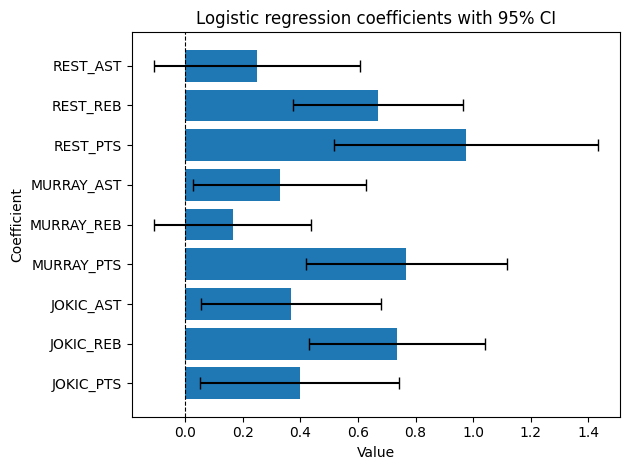

In [16]:
# Extract all coefficients but the Intercept
summary = log_reg1.summary2().tables[1].iloc[:-1,:]

# Extract the names, the estimates and the values for the error bars
coef_names = summary.index
coef_estimates = summary['Coef.']
coef_error = summary['Coef.'] - summary['[0.025']

# Create a bar plot with error bars
plt.barh(coef_names, coef_estimates, xerr = coef_error, capsize = 4)
plt.xlabel('Value')
plt.ylabel('Coefficient')
plt.title('Logistic regression coefficients with 95% CI')
plt.axvline(x = 0, color = 'black', linewidth = 0.8, linestyle = '--') # Add vertical line at zero
plt.tight_layout()
plt.show()

### 2.3. SHAP values

SHAP (SHapley Additive exPlanations) values is a method based on cooperative game theory used to increase the interpretability of ML models. Their essence is to measure the contributions from each player to the final outcome, while preserving the sum of contributions as the final outcome.

SHAP values allow us to measure each feature's contribution to an individual prediction. Moreover, by aggregating SHAP values, we can also understand trends across multiple predictions.

- [Introduction to SHAP with Python](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)
- [Using SHAP values to explain how your machine learning model works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
- [How to interpret and explain your machine learning models using SHAP values](https://m.mage.ai/how-to-interpret-and-explain-your-machine-learning-models-using-shap-values-471c2635b78e)
- [A comprehensive guide into SHAP (SHapley Additive exPlanations) values](https://deepchecks.com/a-comprehensive-guide-into-shap-shapley-additive-explanations-values/)
- [Inconsistent usage of 'shap_value' in beeswarm](https://github.com/shap/shap/issues/1460)

To the best of my knowledge, SHAP doesn't work with `statsmodels`. Thus, we start by fitting the model using `scikit-learn`.

In [17]:
log_reg1_sl = LogisticRegression(max_iter = 200)
log_reg1_sl.fit(X_train1[cols], y_train)

LogisticRegression(max_iter=200)

Let's calculate the SHAP values.

In [18]:
explainer = shap.Explainer(log_reg1_sl, X_train1[cols])
shap_values = explainer.shap_values(X_train1[cols])

The following bar plot tells us which features are most important to determine the model's predictions. It plots the global effect of each feature by calculating the mean absolute SHAP value across all observations, sorting the features from the most to the least important. The length of each bar corresponds to each feature's mean absolute SHAP value.

According to this bar plot, Murray's points are more important than Jokic's assists, i.e., the former have a larger impact on the model's predictions. Specifically, Murray's points increase the log odds of winning by 0.56, while Jokic's assists increase the log odds of winning by 0.31 (the mean absolute SHAP values are computed in the cell right after the bar plot).

Note that sorting the features according to the SHAP values and the standardized coefficients results in almost the same order. There's only one swap: Jokic's assists and Jokic's points. While this result is interesting, there's no much we can gain from it to answer our question of interest.

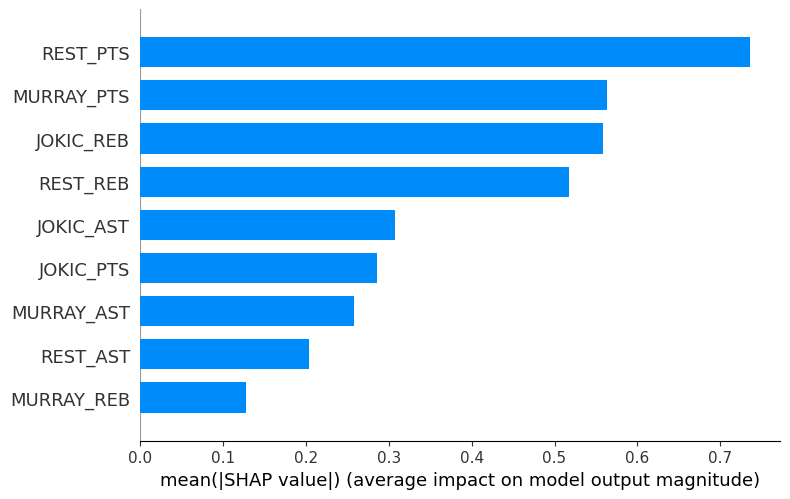

In [19]:
shap.summary_plot(shap_values, X_train1[cols], plot_type = 'bar')

In [20]:
# Bring the shap values to a DataFrame 
shap_values_df = pd.DataFrame(shap_values, columns = cols)

# Compute the mean absolute SHAP value for each feature, placing each mean in a row at the end of the DataFrame
shap_values_df.loc[len(shap_values_df)] = [np.mean(np.abs(shap_values_df[column].values)) for column in shap_values_df]

# Let's check them out
shap_values_df.tail(1)

,JOKIC_PTS,JOKIC_REB,JOKIC_AST,MURRAY_PTS,MURRAY_REB,MURRAY_AST,REST_PTS,REST_REB,REST_AST
372,0.286337,0.558656,0.307952,0.563176,0.127697,0.257834,0.735156,0.517725,0.2034


The following beeswarm plot not only sorts the features by their importance but also shows all SHAP values and how large and small values of the features affect the model's predictions.

For example, increasing Murray's points increases the SHAP values. While the same holds for Jokic's assists, there seems to be more positive SHAP values for Murray's points and several of them are larger than the largest one for Jokic's assists. The violin plot in the cell right after the beeswarm plot shows a neater visualization.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


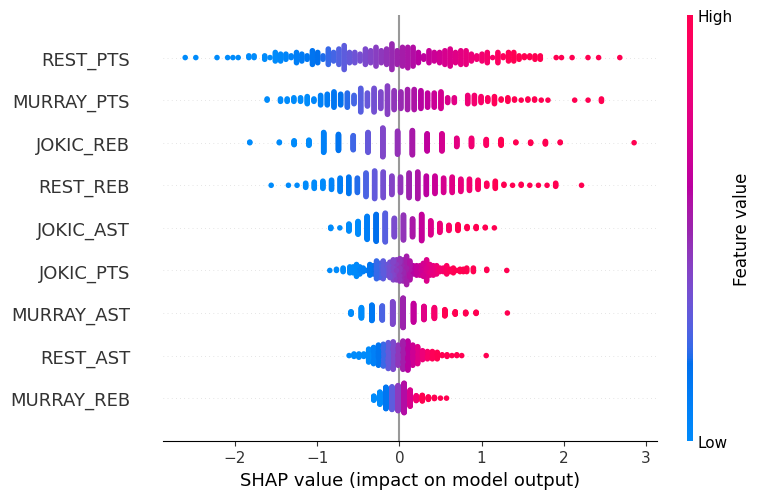

In [21]:
shap.summary_plot(shap_values, X_train1[cols])
#shap.plots.beeswarm(explainer(X_train1[cols])) delivers the same plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


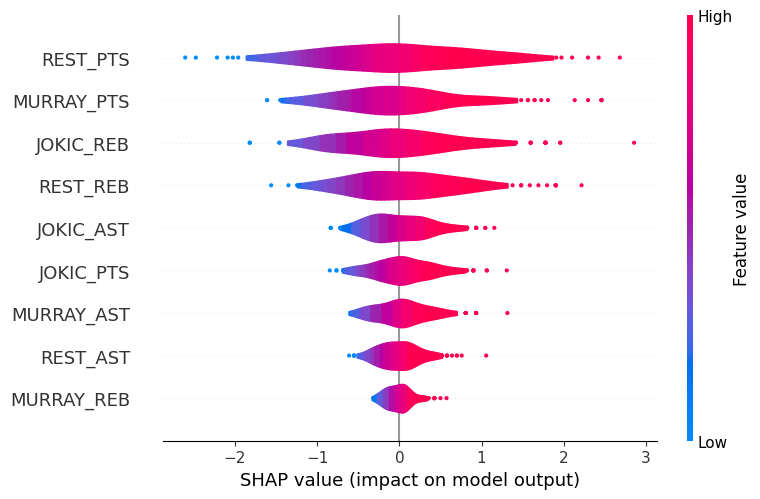

In [22]:
shap.summary_plot(shap_values, X_train1[cols], plot_type = 'violin')

While above we focused on the overall importance of each feature, SHAP can also be used to check the importance of each feature for a particular observation, in this case, for a particular game. I leave the code for two plots:

```python
shap.plots.waterfall(explainer(X_train1[cols])[-1])
```

```python
shap.initjs()
shap.plots.force(explainer(X_train1[cols])[-1])
```

### 2.4. Discussion

While the numbers from the standardized logistic regression and the SHAP values suggest Murray's points are more important than Jokic's assists to determine whether the Nuggets win a game, caution is advised. First, the comparison of the two coefficients from the logistic regression doesn't show a clear-cut difference between them; it shows a marginal difference at best. And second, to the best of my knowledge, there doesn't seem to be a way to statistically compare SHAP values as we did with the regression coefficients.

Nevertheless, this exercise can still provide valuable insights into understanding how different stats contribute to determine whether the Nuggets win a game.

## 3. Model comparison

### Akaike Information Criterion

We can use the Akaike Information Criterion ($AIC$) to compare models (we'll compare this model against another model we'll estimate below). The $AIC$ is a measure of a model's relative quality for a given dataset. Thus, it can be used for model selection. Its formula is as follows:

$AIC = 2k - 2ln(L),$

where $k$ is the number of estimated parameters and $L$ is the maximized value of the likelihood function. The second term rewards goodness of fit, while the first one penalizes a large dimension, discouraging overfitting. Thus, the $AIC$ aims to balance goodness of fit and model simplicity, where smaller $AIC$ indicate a better balance. Thus, given a set of models, the preferred model is the one with the smallest $AIC$.

Note that the regression output provides the term $ln(L)$ under the label $Log-Likelihood$. Thus:

$AIC = 2 \times 10 - 2 \times (-186.08) = 392.16$

We can also retrieve the $AIC$ using `statsmodels` tools (see the cell below).

In [23]:
log_reg1.aic

392.1578228102163

### Removing one variable following the EDA

According to the EDA, the points from the rest of the teammates have a moderate association with Jokic's points, Murray's points and the assists from the rest of the teammates. We'll remove the points from the rest of the teammates from the model and compare it to the model estimated above.

In [24]:
scaler_s = StandardScaler()
cols2 = ['JOKIC_PTS', 'JOKIC_REB', 'JOKIC_AST', 'MURRAY_PTS', 'MURRAY_REB', 'MURRAY_AST', 'REST_REB', 'REST_AST']
X_train2 = pd.DataFrame(scaler_s.fit_transform(data[cols2]), columns = cols2)
X_train2['Intercept'] = 1
log_reg2 = sm.Logit(y_train,  X_train2).fit()
print(log_reg2.summary())

Optimization terminated successfully.
         Current function value: 0.525975
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    WIN   No. Observations:                  372
Model:                          Logit   Df Residuals:                      363
Method:                           MLE   Df Model:                            8
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                  0.1989
Time:                        18:16:35   Log-Likelihood:                -195.66
converged:                       True   LL-Null:                       -244.24
Covariance Type:            nonrobust   LLR p-value:                 1.622e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JOKIC_PTS     -0.0121      0.140     -0.086      0.932      -0.287       0.263
JOKIC_REB      0.6982      0.

In [25]:
log_reg2.aic

409.325443626576

According to the $AIC$, the model that includes the points from the rest of the teammates is preferred.